In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from pmdarima.arima import auto_arima
from pmdarima import model_selection
import pmdarima as pm


In [4]:
import pandas as pd

df = pd.read_csv('2023-05-25-file-1.csv', sep=";", header = 0)
df["unix_time"] = pd.to_datetime(df["unix_time"], unit='s')
#print(df)
df = df.drop(['id'], axis=1)# specify axis=1 to drop columns
df['value'] = pd.to_numeric(df['value'])
print(df.head())
print(df.dtypes)

            unix_time     value
0 2023-05-14 07:29:44  1.989379
1 2023-05-14 07:30:44  1.463045
2 2023-05-14 07:31:44  1.480181
3 2023-05-14 07:32:44  5.955714
4 2023-05-14 07:33:44  8.389520
unix_time    datetime64[ns]
value               float64
dtype: object


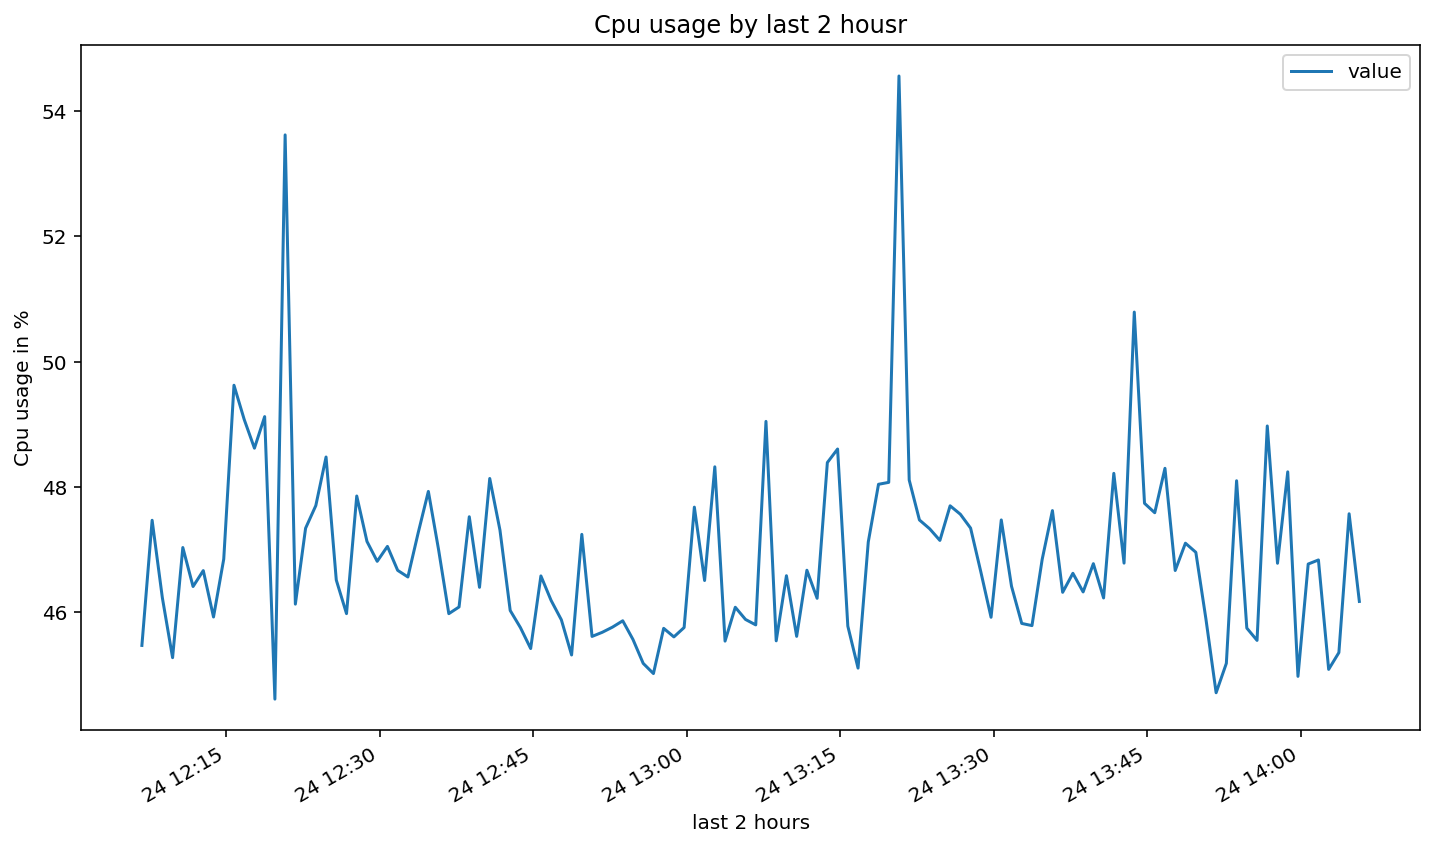

In [5]:
import matplotlib.pyplot as plt

df.tail(120).plot(x='unix_time', y='value', kind='line')
plt.title("Cpu usage by last 2 housr")
plt.xlabel("last 2 hours")
plt.ylabel("Cpu usage in %")
plt.show()

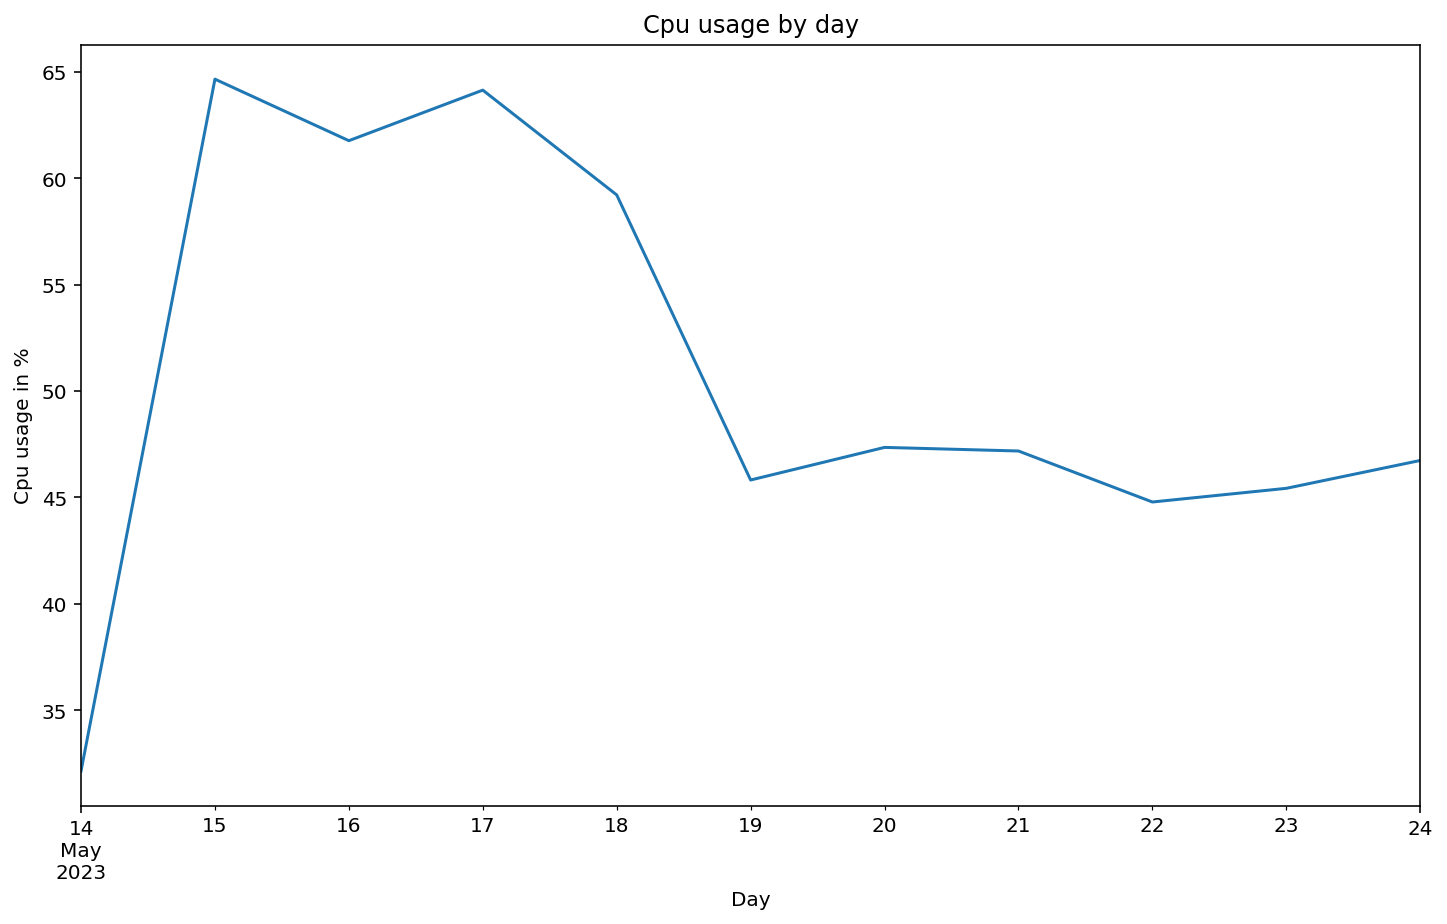

In [6]:
weekly_summary = df.set_index('unix_time')['value'].resample('D').mean()
weekly_summary.plot()
plt.title("Cpu usage by day")
plt.xlabel("Day")
plt.ylabel("Cpu usage in %")
plt.show()

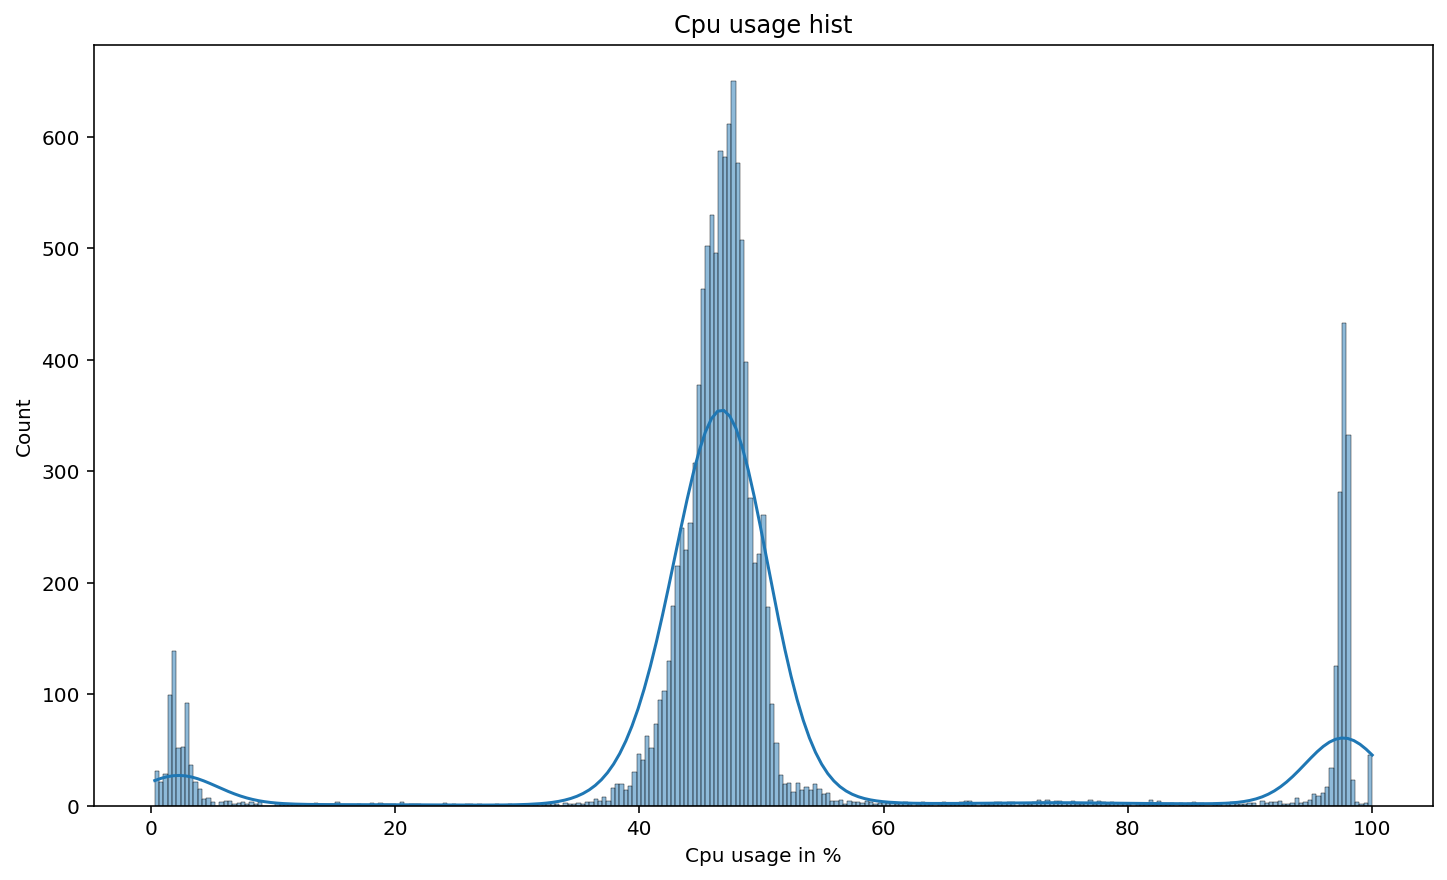

In [7]:
sns.histplot(data=df, x="value", kde=True)
plt.title("Cpu usage hist")
plt.xlabel("Cpu usage in %")
plt.ylabel("Count")
plt.show()

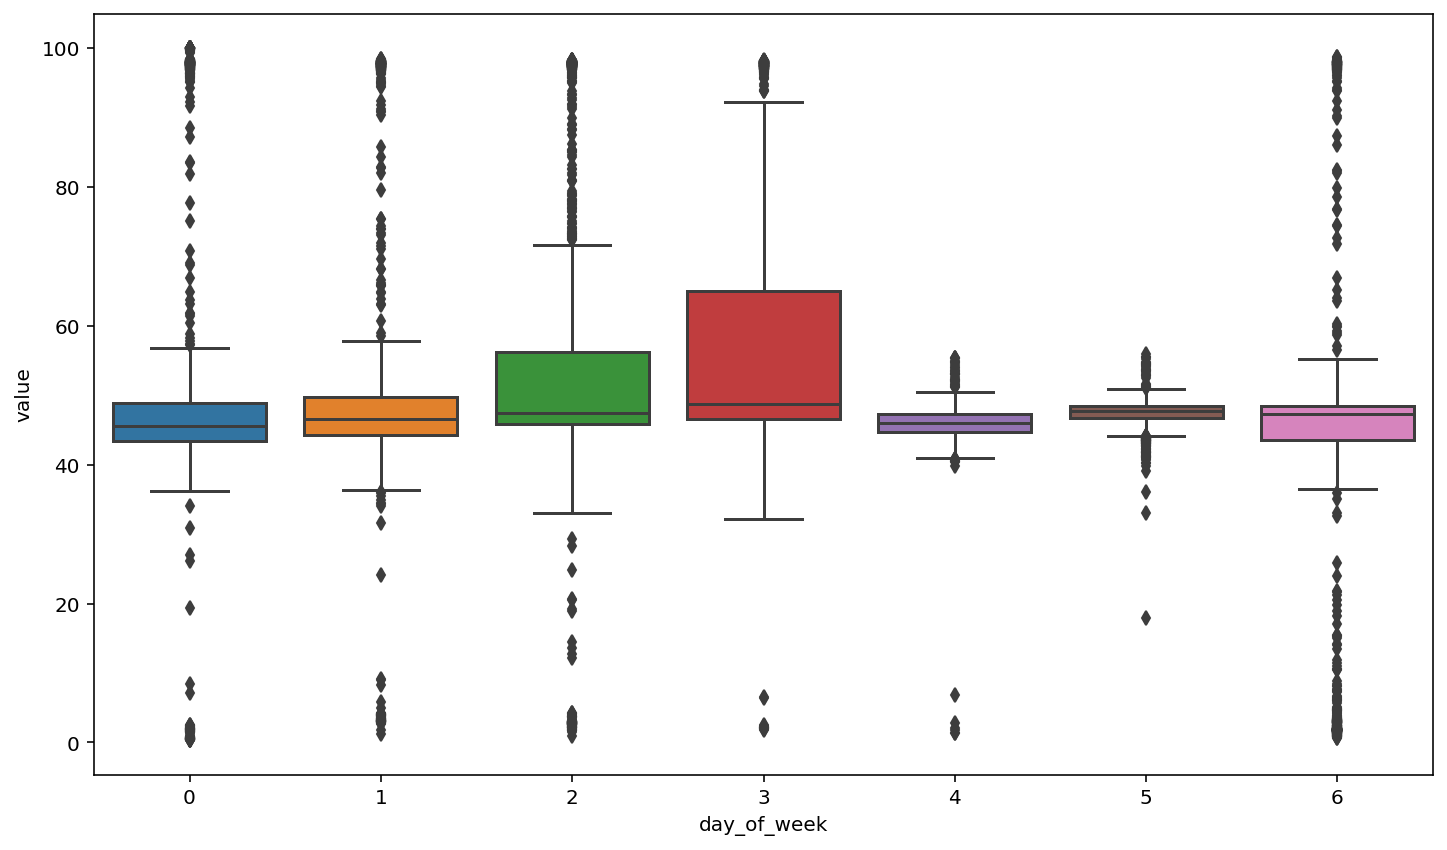

In [8]:
df["day"] = df['unix_time'].dt.day
df["day_of_week"] = df['unix_time'].dt.dayofweek
sns.boxplot(data=df, x="day_of_week", y="value")
plt.show()

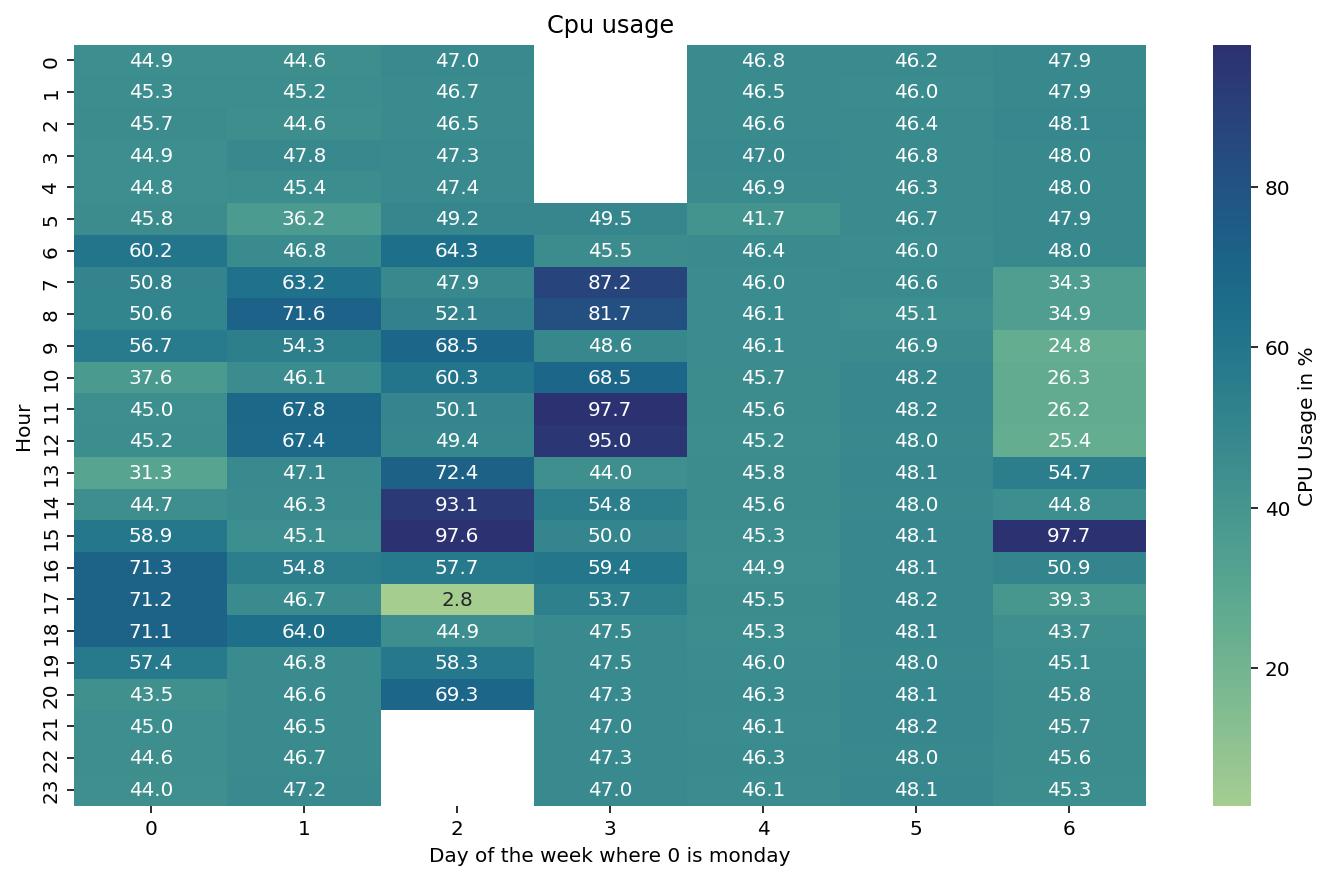

In [9]:
df["hours"] = df['unix_time'].dt.hour
dfq = df.groupby(["day_of_week", "hours"]).mean()

# re-format the data for the heat-map
df_day_hour = dfq.reset_index().pivot(index="hours", columns="day_of_week", values="value")

# create heatmap
sns.heatmap(df_day_hour, cbar_kws={"label": "CPU Usage in %"}, fmt=".1f", annot=True, cmap="crest")
plt.title("Cpu usage")
plt.xlabel("Day of the week where 0 is monday")
plt.ylabel("Hour")
plt.show()

In [10]:
print(df)

                unix_time      value  day  day_of_week  hours
0     2023-05-14 07:29:44   1.989379   14            6      7
1     2023-05-14 07:30:44   1.463045   14            6      7
2     2023-05-14 07:31:44   1.480181   14            6      7
3     2023-05-14 07:32:44   5.955714   14            6      7
4     2023-05-14 07:33:44   8.389520   14            6      7
...                   ...        ...  ...          ...    ...
12211 2023-05-24 14:01:44  46.832558   24            2     14
12212 2023-05-24 14:02:44  45.085995   24            2     14
12213 2023-05-24 14:03:44  45.354316   24            2     14
12214 2023-05-24 14:04:44  47.569927   24            2     14
12215 2023-05-24 14:05:44  46.170452   24            2     14

[12216 rows x 5 columns]


In [13]:
data = pd.read_csv('2023-05-25-file-1.csv', sep=";", header = 0)

data['unix_time'] = data[('unix_time')].values.astype("float64") /10**9
data = data.set_index('unix_time')['value']
##data["unix_time"] = pd.to_datetime(data["unix_time"], unit='s')
print(data.head())
##daily_summary = data.set_index('unix_time')['value'].resample('H').mean()
#daily_summary['unix_time'] = daily_summary[('unix_time')].values.astype("float64")
#data = daily_summary.dropna()
print(data)


unix_time
1.684049    1.989379
1.684049    1.463045
1.684050    1.480181
1.684050    5.955714
1.684050    8.389520
Name: value, dtype: float64
unix_time
1.684049     1.989379
1.684049     1.463045
1.684050     1.480181
1.684050     5.955714
1.684050     8.389520
              ...    
1.684937    46.832558
1.684937    45.085995
1.684937    45.354316
1.684937    47.569927
1.684937    46.170452
Name: value, Length: 12216, dtype: float64


In [14]:
TEST_SIZE = 5
Q = 600
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
#train, test = data.iloc[-Q:-TEST_SIZE], data.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
#x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.tail(600).shape[0]))
#train.shape, x_train.shape, test.shape, x_test.shape
print(train)

unix_time
1.684049     1.989379
1.684049     1.463045
1.684050     1.480181
1.684050     5.955714
1.684050     8.389520
              ...    
1.684937    48.971338
1.684937    46.779661
1.684937    48.239061
1.684937    44.974398
1.684937    46.767446
Name: value, Length: 12211, dtype: float64


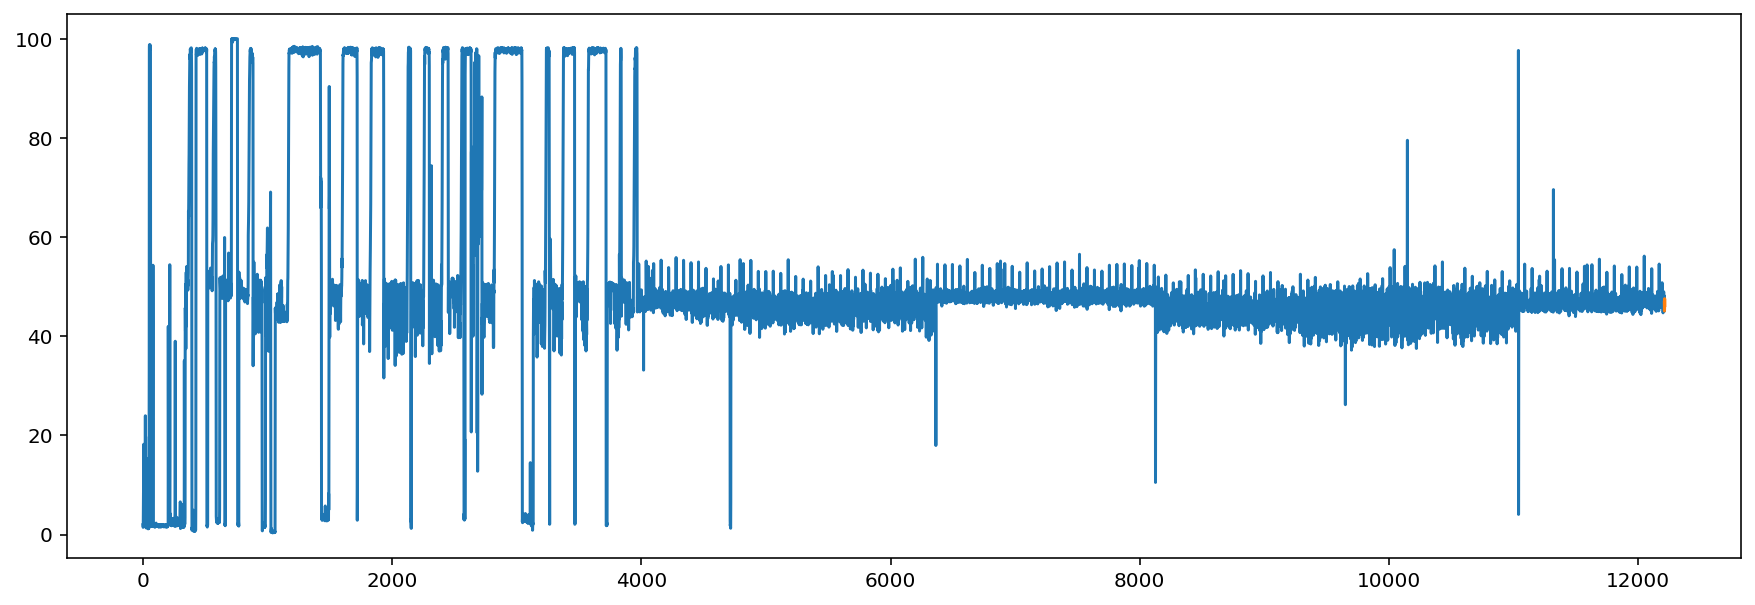

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)
plt.show()

In [16]:

model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,
                      d=2,
                      seasonal=True,
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
model.summary()
prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)

prediction


Performing stepwise search to minimize aic


 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=6.79 sec


 ARIMA(0,2,0)(0,0,0)[0]             : AIC=82869.376, Time=0.50 sec


 ARIMA(1,2,0)(0,0,0)[0]             : AIC=78893.093, Time=0.40 sec


 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=4.49 sec


 ARIMA(2,2,0)(0,0,0)[0]             : AIC=77182.831, Time=1.11 sec


 ARIMA(3,2,0)(0,0,0)[0]             : AIC=76179.595, Time=2.00 sec


 ARIMA(4,2,0)(0,0,0)[0]             : AIC=75648.774, Time=2.80 sec


 ARIMA(5,2,0)(0,0,0)[0]             : AIC=75387.039, Time=4.00 sec


 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=48.41 sec


 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=40.31 sec


 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=75389.039, Time=6.50 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 117.320 seconds


array([46.83518153, 46.89247994, 46.51344834, 46.48371716, 46.30661631])

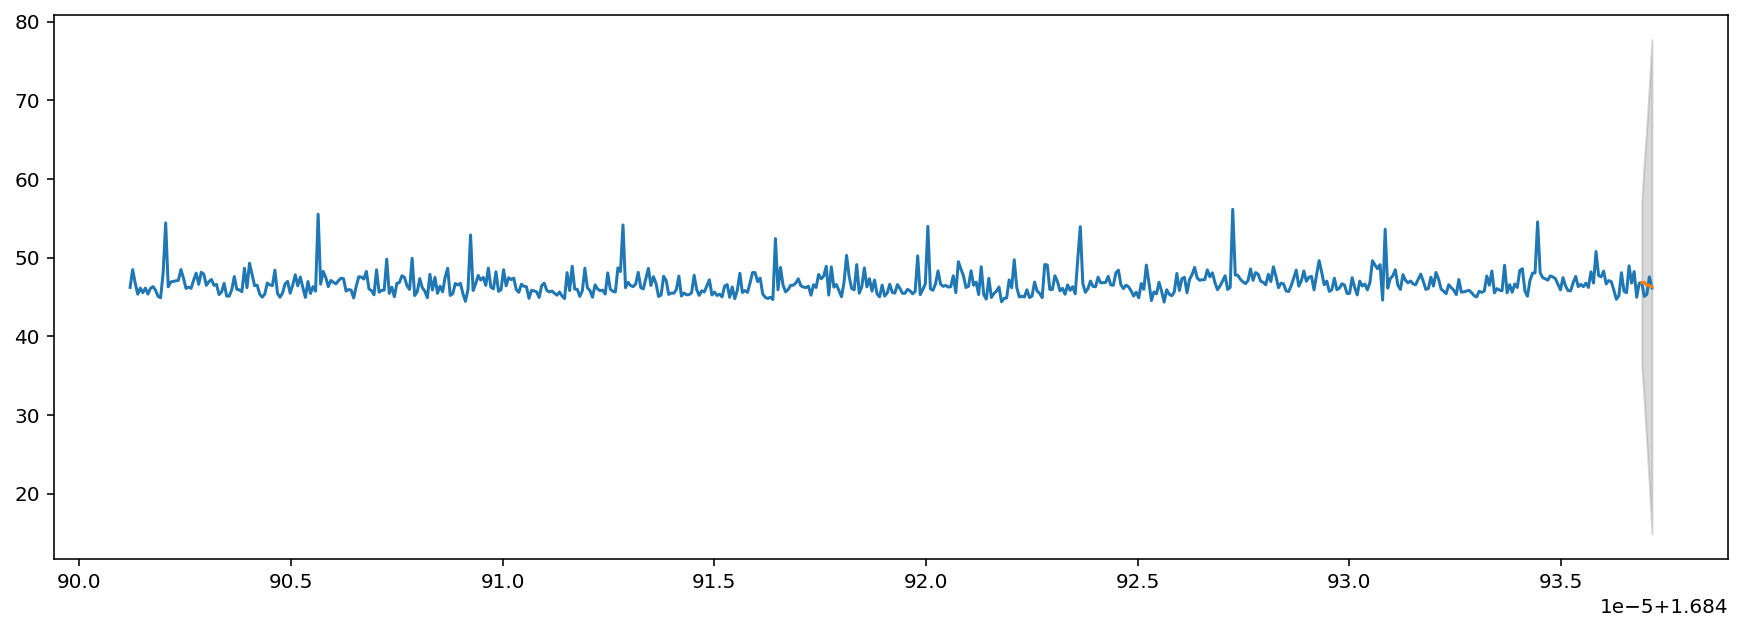

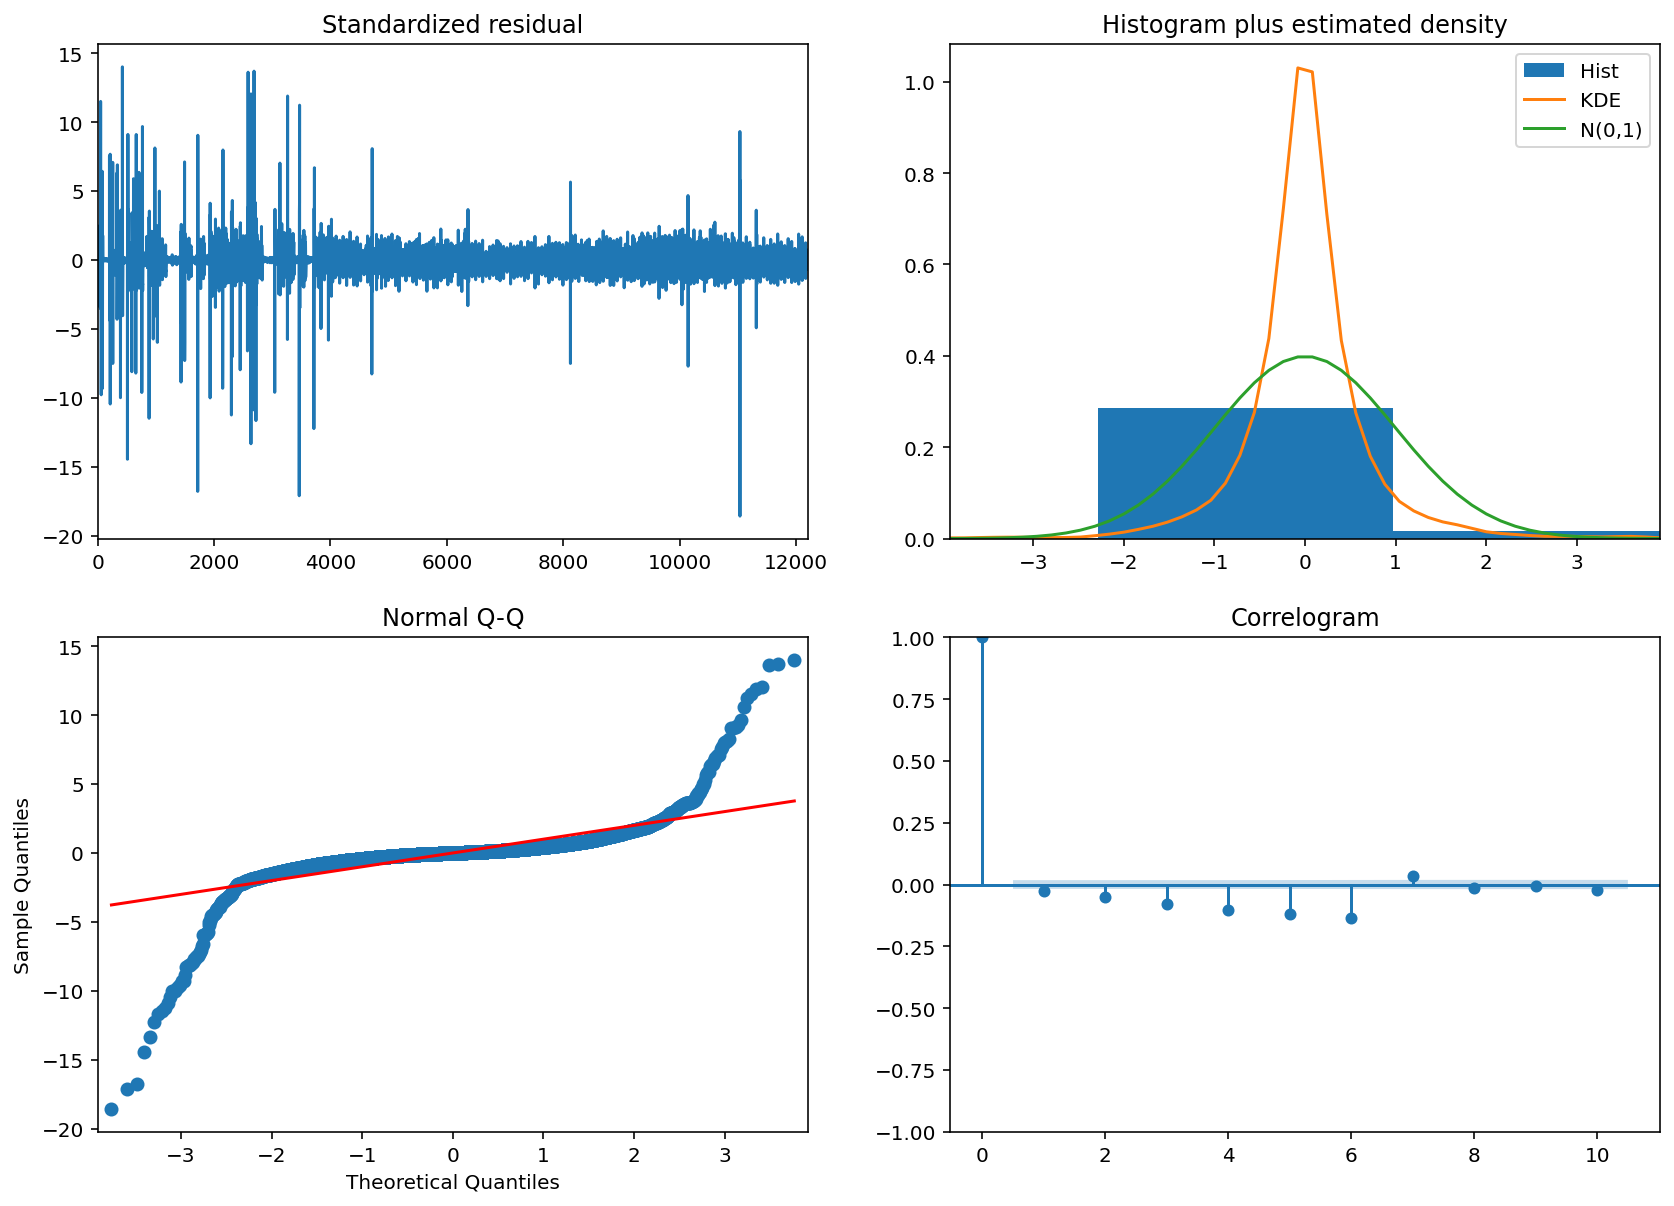

In [18]:
cf= pd.DataFrame(confint)
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#ax.plot(data)
ax.plot(data.tail(600))
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
model.plot_diagnostics(figsize=(14,10))
plt.show()